In [ ]:
!pip install bertopic
!pip install convokit
!pip install langchain
!pip install transformers
!pip install firebase-admin
!pip install transformers

In [ ]:
from bertopic import BERTopic
from convokit import Corpus, download
import pandas as pd
import numpy as np
from langchain.llms import HuggingFaceHub
import os
from transformers import pipeline
import firebase_admin
from firebase_admin import credentials, firestore, initialize_app, storage
from transformers import pipeline
import matplotlib.pyplot as plt

In [ ]:
cred = credentials.Certificate("/content/ming-527ed-firebase-adminsdk-z38ui-431c72dad9.json")
firebase_admin.initialize_app(cred)

In [ ]:
db = firestore.client()

# Loading Corpus

In [ ]:
corpus = Corpus(filename=download("conversations-gone-awry-corpus"))

No configuration file found at /root/.convokit/config.yml; writing with contents: 
# Default Backend Parameters
db_host: localhost:27017
data_directory: ~/.convokit/saved-corpora
default_backend: mem


In [ ]:
conversations_df = corpus.get_conversations_dataframe()
utterances_df = corpus.get_utterances_dataframe()
speakers_df = corpus.get_speakers_dataframe()

In [ ]:
utterances_df

In [ ]:
class EmotionAnalysis:
    def __init__(self):
        self.classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None,device=0)
        self.emotion_dict = {
            'admiration': '😍',
            'amusement': '😄',
            'anger': '😡',
            'annoyance': '😒',
            'approval': '👍',
            'caring': '❤️',
            'confusion': '😕',
            'curiosity': '🤔',
            'desire': '😏',
            'disappointment': '😞',
            'disapproval': '👎',
            'disgust': '🤢',
            'embarrassment': '😳',
            'excitement': '😃',
            'fear': '😨',
            'gratitude': '🙏',
            'grief': '😢',
            'joy': '😁',
            'love': '❤️',
            'nervousness': '😬',
            'neutral': '😐',
            'optimism': '😊',
            'pride': '🏆',
            'realization': '💡',
            'relief': '😌',
            'remorse': '😔',
            'sadness': '😢',
            'surprise': '😲'
        }

    def __call__(self, sentences):
        #if sentences == "" or sentences == []:
           # return

        if isinstance(sentences, str):
            sentences = [sentences]

        for i, sentence in enumerate(sentences):
            if len(sentence) > 512:
                sentences[i] = sentence[-512:]


        model_outputs = self.classifier(sentences)
        emotion = model_outputs[0][0]['label']
        if emotion == 'neutral':
            emotion = model_outputs[0][1]['label']
        emoji = self.emotion_dict[emotion]
        return model_outputs, emotion, emoji

In [ ]:
classifier = EmotionAnalysis()


In [ ]:
def process_conversations(conversations_df, utterances_df, speakers_df):
    # Filter and merge dataframes
    merged_df = pd.merge(utterances_df, speakers_df, left_on='speaker', right_index=True)
    merged_df = pd.merge(merged_df, conversations_df, left_on='conversation_id', right_index=True)

    # Process each conversation

    convo_records = []
    convo_texts = []
    convo_speakers = {}
    convo_speakers_texts = {}
    for convo_id, convo_data in merged_df.groupby('conversation_id'):
        # Calculate total personal attacks and average toxicity
        total_attacks = convo_data['meta.comment_has_personal_attack'].sum()
        avg_toxicity = convo_data['meta.toxicity'].mean()

        # Get conversation start time
        start_time = convo_data['timestamp'].min()

        # Calculate embeddings for the conversation
        convo_text = ' '.join(convo_data['text'].tolist())
        #embeddings = calculate_embeddings(convo_text)

        # Prepare data for Firebase
        convo_record = {
            'convo_id': convo_id,
            'total_personal_attacks': total_attacks,
            'average_toxicity': avg_toxicity,
            'start_time': start_time,
            #'embeddings': embeddings,
            # Include additional metadata as needed
        }

        # Get speakers
        speakers = []
        speaker_texts = {}
        for speaker_id, speaker_data in convo_data.groupby('speaker'):
            speaker_text = ' '.join(speaker_data['text'].tolist())

            speaker_texts[speaker_id] = speaker_text
            a ,speaker_emotion, speaker_emoji = classifier(speaker_text)
            speaker_record = {
                'speaker_id': speaker_id,
                'emotion': speaker_emotion,
                'emoji': speaker_emoji,
                # Include additional metadata as
            }
            speakers.append(speaker_record)

        #convo_speakers.append(convo_speaker)
        convo_speakers_texts[convo_id] =  speaker_texts
        convo_speakers[convo_id] = speakers

        convo_texts.append(convo_text)
        convo_records.append(convo_record)
        # Save to Firebase
        #db.collection('conversations').document(convo_id).set(convo_record)

    print("Processed Convo Texts")
    return convo_records, convo_texts, convo_speakers, convo_speakers_texts

meaningfull labels
similarities for the clusters
emotions model to work on classifying speakers on emotions. then turn the emotions




In [ ]:
convo_records, convo_texts, convo_speakers, convo_speakers_text  = process_conversations(conversations_df, utterances_df, speakers_df) #.head(1000)

Processed Convo Texts


In [ ]:
convo_id = convo_records[0]["convo_id"]

In [ ]:
merged_df = pd.merge(utterances_df, speakers_df, left_on='speaker', right_index=True)
merged_df = pd.merge(merged_df, conversations_df, left_on='conversation_id', right_index=True)

df = merged_df[merged_df['conversation_id'] == convo_id ].sort_values('timestamp', ascending=True)

df

In [ ]:
convo_records[0]["convo_id"]

'100009118.8296.8296'

In [ ]:
corpus.get_conversation(convo_records[0]["convo_id"])

Conversation({'obj_type': 'conversation', 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7e4b5c5c3f40>, 'id': '100009118.8296.8296', 'meta': ConvoKitMeta({'page_title': 'User talk:Hiding', 'page_id': 1736103, 'pair_id': '97814179.5675.5675', 'conversation_has_personal_attack': True, 'verified': True, 'pair_verified': True, 'annotation_year': '2018', 'split': 'train'})})

In [ ]:
corpus.get_conversation("407508250.100949.100949")

Conversation({'obj_type': 'conversation', 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7e4b5c5c3f40>, 'id': '407508250.100949.100949', 'meta': ConvoKitMeta({'page_title': 'Talk:Centrifugal force (rotating reference frame)', 'page_id': 7533, 'pair_id': '407511340.101821.101821', 'conversation_has_personal_attack': True, 'verified': False, 'pair_verified': False, 'annotation_year': '2019', 'split': 'val'})})

In [ ]:
convo_speakers['182614870.5054.5054']

[{'speaker_id': 'Ammar shaker', 'emotion': 'remorse', 'emoji': '😔'},
 {'speaker_id': 'Dino246', 'emotion': 'confusion', 'emoji': '😕'},
 {'speaker_id': 'Typ932', 'emotion': 'confusion', 'emoji': '😕'}]

In [ ]:
convo_speakers_text['204073727.3013.3013']

{'216.21.150.44': ' I have read through all of the dialogue from the music project. There are almost 20 regular editors and use comma delimiters as their standard spacing and 2 regular editors who were involved in an edit war over the matter and have both received blocks from Wikipedia administration because of their negative contributions. I will go with the consensus of the credible editors and not the others.',
 'Navnløs': "\n== Genre delimiters ==  Please stop changing genre delimiters. Consensus is to leave them the way they are now.  Changing them incites edit warring.  I could just as easliy cite wiki_link and put them back to line breaks.  So citing wiki_link for genre delimiters changes nothing. Please stop.  Thank you.  That is a downright lie, unless you're talking about recently (which I wouldn't know as I no longer argue about those stupid things), but I know there was a consensus made (that the majority of editors follow, incl. admins) to not change genre delimiters as it

In [ ]:
convo_speakers['211754039.54581.54581']

[{'speaker_id': 'Karasek', 'emotion': 'amusement', 'emoji': '😄'},
 {'speaker_id': 'Matthead', 'emotion': 'neutral', 'emoji': '😐'},
 {'speaker_id': 'Molobo', 'emotion': 'curiosity', 'emoji': '🤔'},
 {'speaker_id': 'Xx236', 'emotion': 'confusion', 'emoji': '😕'}]

# Do Clustering

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2",vectorizer_model=vectorizer_model,nr_topics=100)#calculate_probabilities=True)

In [ ]:
topics, probs = topic_model.fit_transform(convo_texts)
new_topics = topic_model.reduce_outliers(convo_texts, topics, strategy="c-tf-idf")
new_topics = topic_model.reduce_outliers(convo_texts, topics, strategy="distributions")
new_topics = topic_model.reduce_outliers(convo_texts, topics, strategy="embeddings")

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1762,-1_article_just_page_sources,"[article, just, page, sources, wikipedia, like...","[And after that debate, the article was left w..."
1,0,12,0_muhammad_depictions_images_image,"[muhammad, depictions, images, image, pictures...",[Any attempt at religious censorship will be r...
2,1,122,1_image_images_picture_photo,"[image, images, picture, photo, use, pictures,...",[Why would one need photoshop to create an acc...
3,2,21,2_al_rebels_sohr_nusra,"[al, rebels, sohr, nusra, map, pro, masdar, re...",[translation from sohr eng: http://syriahr.com...
4,3,70,3_medical_diet_disease_research,"[medical, diet, disease, research, doctors, ef...","[To be picky MEDRS is not quite ""a guideline f..."
5,4,24,4_chinese_japanese_goguryeo_korean,"[chinese, japanese, goguryeo, korean, china, k...","[Those ""chapters"" are further elaborations for..."
6,5,15,5_rfc_pejorative_requests_for_comment_correctness,"[rfc, pejorative, requests_for_comment, correc...",[RfC has become pointless due to heave off-Wik...
7,6,41,6_species_subspecies_reptile_tortoise,"[species, subspecies, reptile, tortoise, creat...",[Just a comment on this issueEditors on scienc...
8,7,14,7_station_stations_square_gateway,"[station, stations, square, gateway, railway, ...","[Maiden Lane, GNR. Temporary terminus from 8 A..."
9,8,23,8_china_taiwan_roc_align,"[china, taiwan, roc, align, manchuria, 000, ma...",[Please don't add some fringe interpretation o...


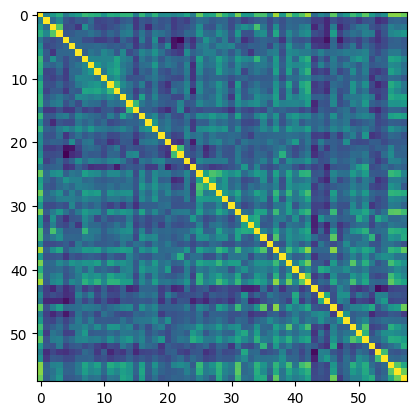

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

distance_matrix = cosine_similarity(np.array(topic_model.topic_embeddings_)[:, :])
labels = (topic_model.get_topic_info().sort_values("Topic", ascending=True).Name)[1:]
plt.imshow(distance_matrix)

In [ ]:
topic_list = topic_model.topic_labels_

topic_list.keys()

dict_keys([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56])

# Set Up Data for Firebase

In [ ]:
label_records = []

for i in topic_list.keys():
  label_record = {}
  label_record['topic'] = i
  topic_words = [token[0] for token in topic_model.get_topic(i)]
  topic_name = topic_words[0]
  for topic_word in topic_words[1:4]:
    topic_name += "_" + topic_word
  label_record['topic_name'] = topic_name

  sim = distance_matrix[i+1]
  for j in range(len(sim)):
    label_record[str(j-1)] = float(sim[j])

  label_records.append(label_record)

for i in range(len(convo_records)):
    convo_records[i]['topic'] = topics[i]

    topic_words = [token[0] for token in topic_model.get_topic(topics[i])]
    topic_name = topic_words[0]
    for topic_word in [token[0] for token in topic_model.get_topic(topics[i])][1:4]:
      topic_name += "_" + topic_word

    convo_records[i]['topic_name'] = topic_name
    convo_records[i]['probs_per_topic'] = probs[i]

In [ ]:
label_records[6]

In [ ]:
convo_records[0]

{'convo_id': '100009118.8296.8296',
 'total_personal_attacks': 1,
 'average_toxicity': 0.28995347,
 'start_time': 1168531555.0,
 'topic': -1,
 'topic_name': 'article_just_page_sources',
 'probs_per_topic': 0.0}

## Filter out conversations by labels to make it easier to send to firebase

In [ ]:
sorted_conv = {}
for record in label_records:
  for conv in convo_records:
    if record['topic'] == conv['topic']:
      if record['topic'] not in sorted_conv.keys():
        sorted_conv[record['topic']] = [conv]
      else:
        sorted_conv[record['topic']].append(conv)

In [ ]:
sorted_conv[-1][0].keys()

dict_keys(['convo_id', 'total_personal_attacks', 'average_toxicity', 'start_time', 'topic', 'topic_name', 'probs_per_topic'])

In [ ]:
import math
for i, record in enumerate(label_records):
  sum = 0
  count = 0
  for convo_record in sorted_conv[i-1]:
    if math.isnan(convo_record['average_toxicity']):
      continue
    count += 1
    sum += convo_record['average_toxicity']
  if count == 0:
    avg = 0
  else:
    avg = sum/count
  label_records[i]['average_toxicity'] = avg


## Save to Firebase

In [ ]:
for i, label_record in enumerate(label_records):
    topic = label_record['topic']
    topic_id = str(i)
    db.collection('topics1').document(topic_id).set(label_record)
    for j, convo_record in enumerate(sorted_conv[topic]):
        convo_id = convo_record['convo_id']
        db.collection('topics1').document(topic_id).collection('convosations').document(convo_id).set(convo_record)
        for speaker_record in convo_speakers[convo_id]:
            speaker_id = speaker_record['speaker_id']
            db.collection('topics1').document(topic_id).collection('convosations').document(convo_id).collection('speakers').document(speaker_id).set(speaker_record)
print('done')

done


In [ ]:
for i, record in enumerate(convo_records):
    convo_id = record['convo_id']
    db.collection('convo_topics').document(convo_id).set(record)